# Vehicle Detection and Tracking

In [1]:
import numpy as np
import cv2
import glob
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
from sklearn.svm import LinearSVC
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from skimage.feature import hog
from moviepy.editor import VideoFileClip
from scipy.ndimage.measurements import label
from IPython.display import HTML
import itertools
%matplotlib inline

## Utility functions

In [2]:
def load_imgs(path):
    return [mpimg.imread(e) for e in glob.glob(path)]

vehicle_imgs = load_imgs('train_images/vehicles/*/*.png')
non_vehicle_imgs = load_imgs('train_images/non-vehicles/*/*.png')

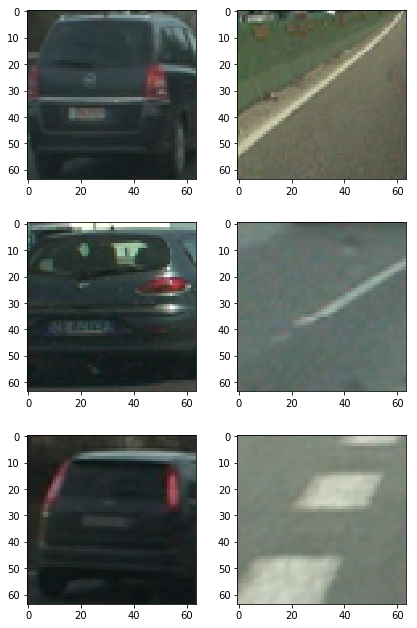

In [3]:
def show_imgs(imgs, titles=None, img_size=(3, 3)):
    n_rows = len(imgs[0])
    n_cols = len(imgs)

    figsize = img_size[0] * n_cols, img_size[1] * n_rows
    fig, axs = plt.subplots(n_rows, n_cols, figsize=figsize)
    fig.tight_layout()

    if n_cols == 1:
        axs = [[ax] for ax in axs]
    
    for row in range(n_rows):
        for col in range(n_cols):
            ax = axs[row][col]
            img = imgs[col][row]
            
            title = '' if titles is None else titles[col]
            
            if isinstance(img, tuple):
                img, title = img
            
            cmap = 'gray' if len(img.shape) == 2 else None
            ax.imshow(img, cmap=cmap)
            ax.set_title(title)

show_imgs([vehicle_imgs[:3], non_vehicle_imgs[:3]])

## HOG features

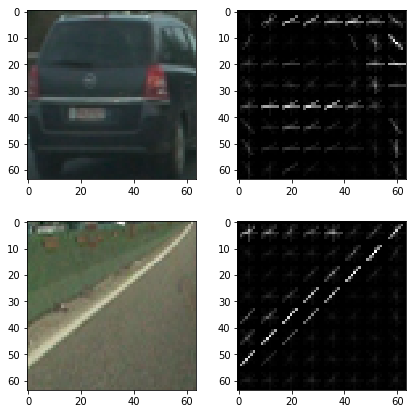

In [4]:
def get_hog_features(img, orient=8, pix_per_cell=8, cell_per_block=2, visualise=False, feature_vector=True):
    return hog(img, orientations=orient, 
        pixels_per_cell=(pix_per_cell, pix_per_cell),
        cells_per_block=(cell_per_block, cell_per_block), 
        transform_sqrt=False, 
        visualise=visualise, 
        feature_vector=feature_vector)

sample_imgs = [vehicle_imgs[0], non_vehicle_imgs[0]]
sample_hog_imgs = [get_hog_features(img[:,:,2], visualise=True)[1] for img in sample_imgs]
show_imgs((sample_imgs, sample_hog_imgs))

### Visualizing color spaces and channels with HOG features

* RGB and HSV show most distinction between vehicle and non-vehicle
* RGB channels seem to be redundant
* HSV channels show distinct features

**Conclusion: Use HSV**

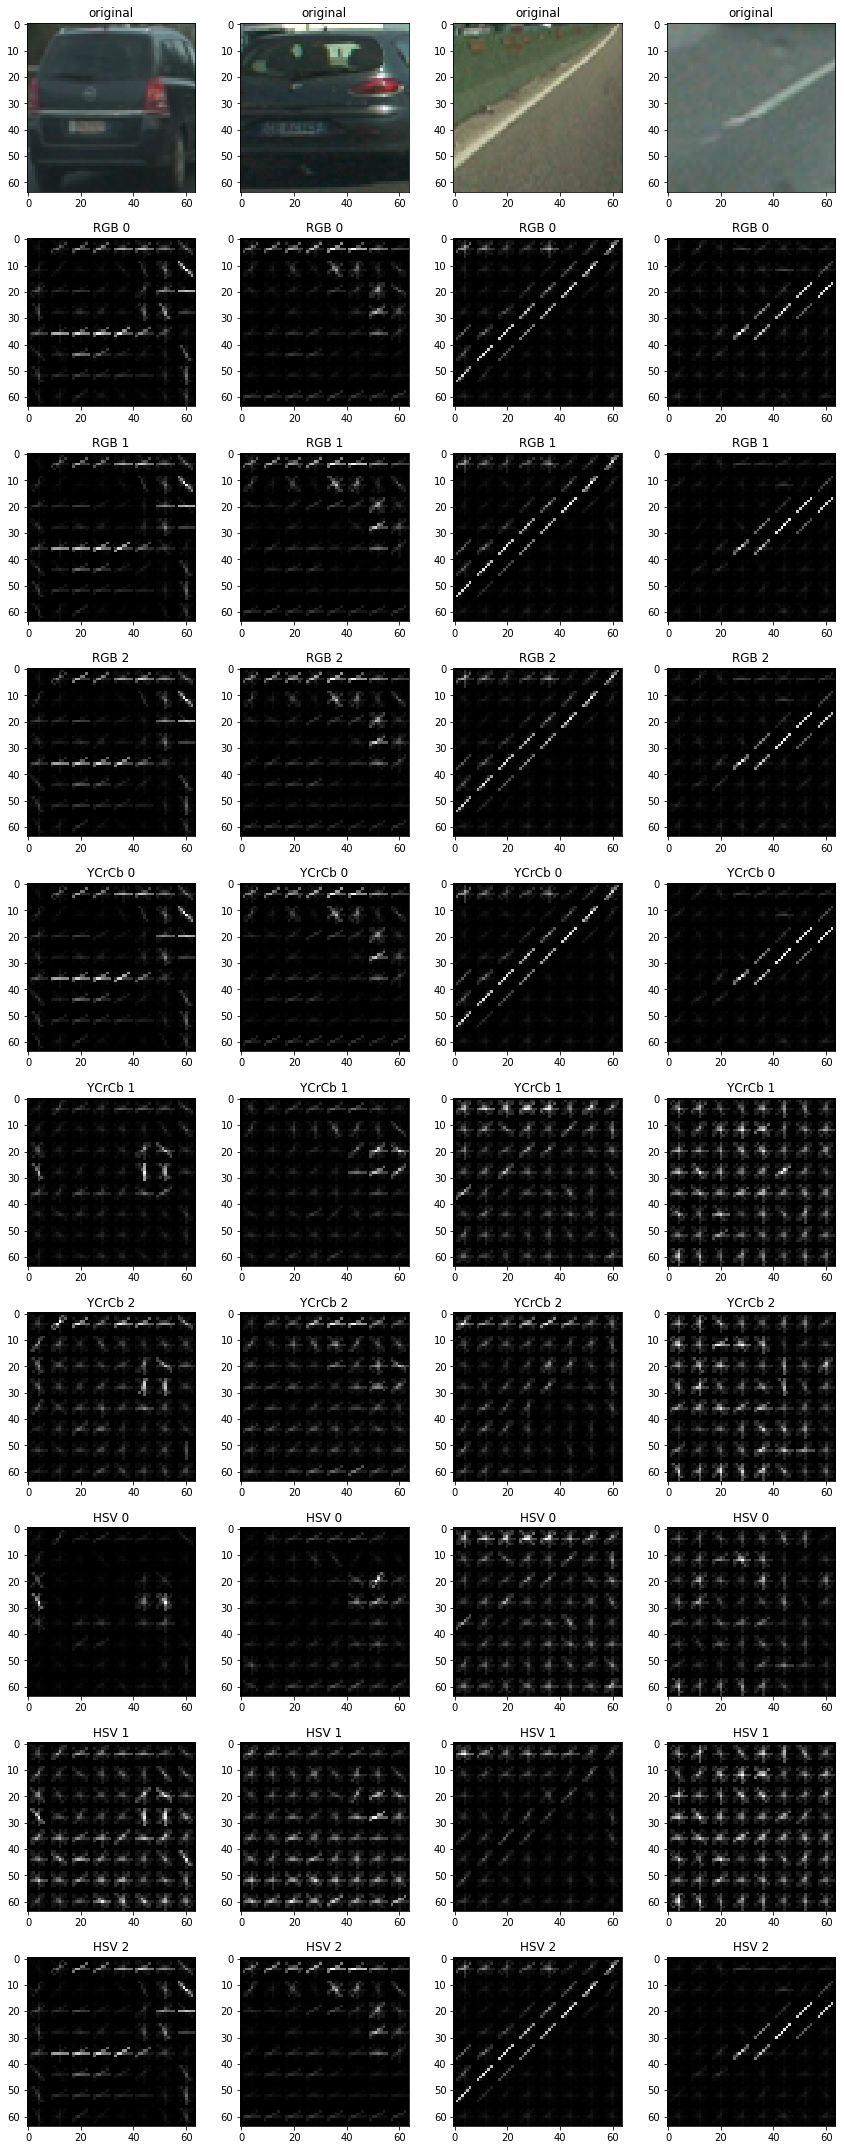

In [5]:
sample_imgs = vehicle_imgs[:2] + non_vehicle_imgs[:2]
spaces = [(None, 'RGB'), (cv2.COLOR_RGB2YCrCb, 'YCrCb'), (cv2.COLOR_RGB2HSV, 'HSV')]
channels = [(0, '0'), (1, '1'), (2, '2')]
output_img_lists = []

for img in sample_imgs:
    output_imgs = [(img, 'original')]
    
    for space, channel in itertools.product(spaces, channels):
        space_img = img if space[0] is None else cv2.cvtColor(img, space[0])
        channel_img = space_img[:,:,channel[0]]
        hog_img = get_hog_features(channel_img, visualise=True)[1]
        output_imgs.append((hog_img, '{} {}'.format(space[1], channel[1])))
    
    output_img_lists.append(output_imgs)
    
show_imgs(output_img_lists)

### Visualizing HOG parameters

- 8 orientations look a little bit cleaner
- 8 pixels per cell provides enough detail
- not much difference for cells per block

**Conclusion: Use 8 orientations, 8 pixels per cell and 2 cells per block**

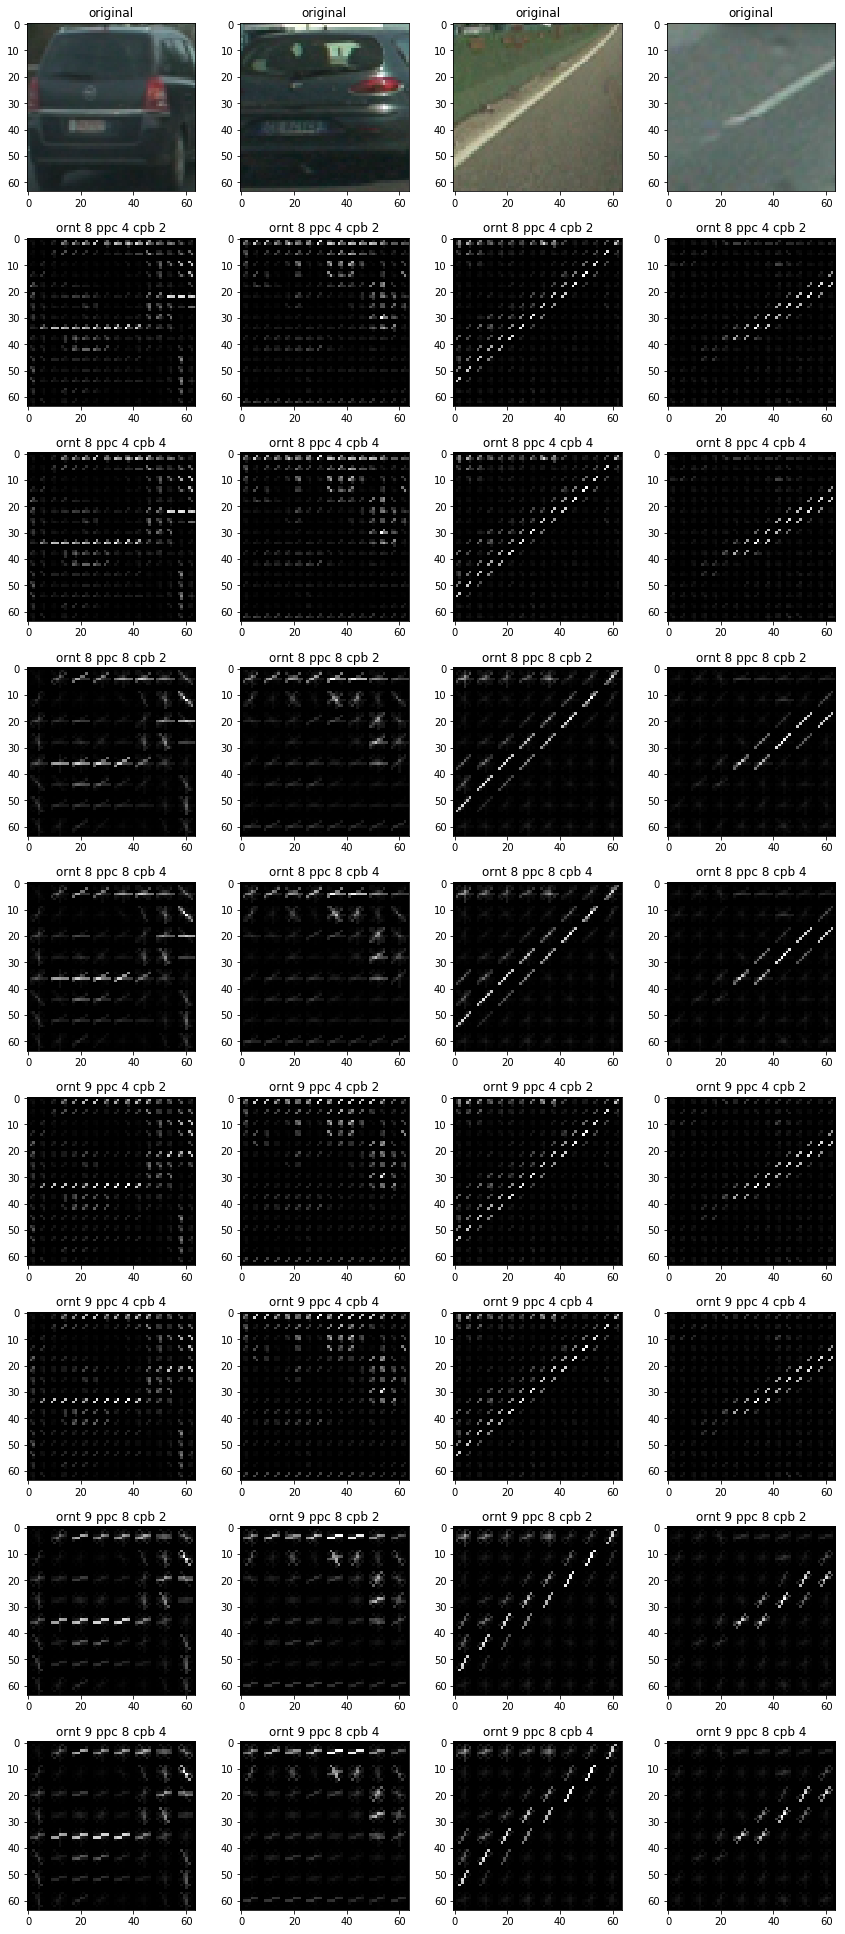

In [6]:
orient_list = [8, 9]
pix_per_cell_list = [4, 8]
cell_per_block_list = [2, 4]

output_img_lists = []

for img in sample_imgs:
    output_imgs = [(img, 'original')]
    
    for orient, pix_per_cell, cell_per_block  in itertools.product(orient_list, pix_per_cell_list, cell_per_block_list):
        space_img = cv2.cvtColor(img, cv2.COLOR_RGB2HSV)
        channel_img = space_img[:,:,2]
        hog_img = get_hog_features(channel_img, orient, pix_per_cell, cell_per_block, visualise=True)[1]
        output_imgs.append((hog_img, 'ornt {} ppc {} cpb {}'
                            .format(orient, pix_per_cell, cell_per_block)))
    
    output_img_lists.append(output_imgs)
    
show_imgs(output_img_lists)

## Color features

## Training a classifier

In [7]:
def extract_spatial_feats(img, size=(32, 32)):
    return np.concatenate([cv2.resize(img[:,:,i], size).ravel() for i in range(3)])
                        
def extract_hist_feats(img, bins=32):
    return np.concatenate([np.histogram(img[:,:,i], bins=bins)[0] for i in range(3)])

def extract_hog_feats(img):
    return np.concatenate([get_hog_features(img[:,:,i]) for i in range(3)])

def extract_hsv_feats(img):
    hsv_img = cv2.cvtColor(img, cv2.COLOR_RGB2HSV)
    return np.concatenate([
        extract_hist_feats(hsv_img),
        extract_hog_feats(hsv_img)
    ])

vehicle_X = [extract_hsv_feats(img) for img in vehicle_imgs]
non_vehicle_X = [extract_hsv_feats(img) for img in non_vehicle_imgs]
X = np.vstack([vehicle_X, non_vehicle_X])
print('X shape ', X.shape)

vehicle_y = np.ones(len(vehicle_imgs))
non_vehicle_y = np.zeros(len(non_vehicle_imgs))
y = np.hstack([vehicle_y, non_vehicle_y])
print('Y shape ', y.shape)

scaler = StandardScaler()
scaler.fit(X)
scaled_X = scaler.transform(X)
print('Scaled X shape ', scaled_X.shape)

X shape  (17760, 4800)
Y shape  (17760,)
Scaled X shape  (17760, 4800)


In [8]:
rand_state = np.random.randint(0, 100)
X_train, X_test, y_train, y_test = train_test_split(scaled_X, y, test_size=0.2, random_state=rand_state)
clf = LinearSVC()
%time clf.fit(X_train, y_train)
print('Test accuracy {:.3f}'.format(clf.score(X_test, y_test)))

CPU times: user 10.4 s, sys: 248 ms, total: 10.7 s
Wall time: 10.7 s
Test accuracy 0.988


## Sliding window search

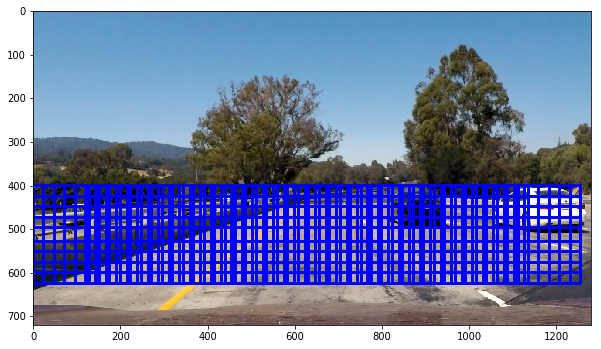

In [84]:
def predict(x):
    scaled_x = scaler.transform(x.reshape(1, -1))
    return clf.predict(scaled_x)     

def draw_boxes(img, boxes, copy=True):
    if copy:
        img = np.copy(img)
    
    for box in boxes:
        cv2.rectangle(img, box[0], box[1], (0, 0, 255), 6)
        
    return img

def find_cars(img, scale=1, y_crop=(400, 656), orient=8, px_per_cell=8, cell_per_block=2, cell_per_step=2, window=64, predict=predict):
    boxes = []
    
    crop_img = img[y_crop[0]:y_crop[1],:,:]
    hsv_img = cv2.cvtColor(crop_img, cv2.COLOR_RGB2HSV)
    hsv_img = cv2.resize(hsv_img, (int(crop_img.shape[1]/scale), int(crop_img.shape[0]/scale)))
        
    hogs = [get_hog_features(hsv_img[:,:,i], orient, px_per_cell, cell_per_block, feature_vector=False) 
            for i in range(3)]
    
    height, width = hsv_img.shape[:2]
    width_block = width//px_per_cell-cell_per_block+1
    height_block = height//px_per_cell-cell_per_block+1 
    feat_per_block = orient*cell_per_block**2
    
    block_per_win = window//px_per_cell-cell_per_block+1
    x_block_steps = (width_block-block_per_win)//cell_per_step
    y_block_steps = (height_block-block_per_win)//cell_per_step
    
    for x_block in range(x_block_steps):
        for y_block in range(y_block_steps):
            x_cell = x_block*cell_per_step
            y_cell = y_block*cell_per_step
            
            hog_feats = np.concatenate(
                [hog[y_cell:y_cell+block_per_win, x_cell:x_cell+block_per_win].ravel() for hog in hogs])
            
            x_left = x_cell*px_per_cell 
            y_top = y_cell*px_per_cell
            
            win_img = hsv_img[y_top:y_top+window, x_left:x_left+window]
            spatial_feats = extract_spatial_feats(win_img)
            hist_feats = extract_hist_feats(win_img)
            
            feats = np.concatenate([hist_feats, hog_feats])
            pred = predict(feats)
            
            if pred == 1:
                pt1 = int(x_left*scale), y_crop[0] + int(y_top*scale)
                pt2 = pt1[0]+int(window*scale), pt1[1]+int(window*scale)
                boxes.append((pt1, pt2))
                
    return boxes 

def show_windows(img):
    boxes = find_cars(img, scale=2, px_per_cell=4, cell_per_block=2, cell_per_step=3, predict=lambda x: 1)
    win_img = draw_boxes(img, boxes)
    plt.figure(figsize = (10,10))
    plt.imshow(win_img)

test_img = load_imgs('test_images/test1.jpg')[0]
show_windows(test_img)

### Tesing scales

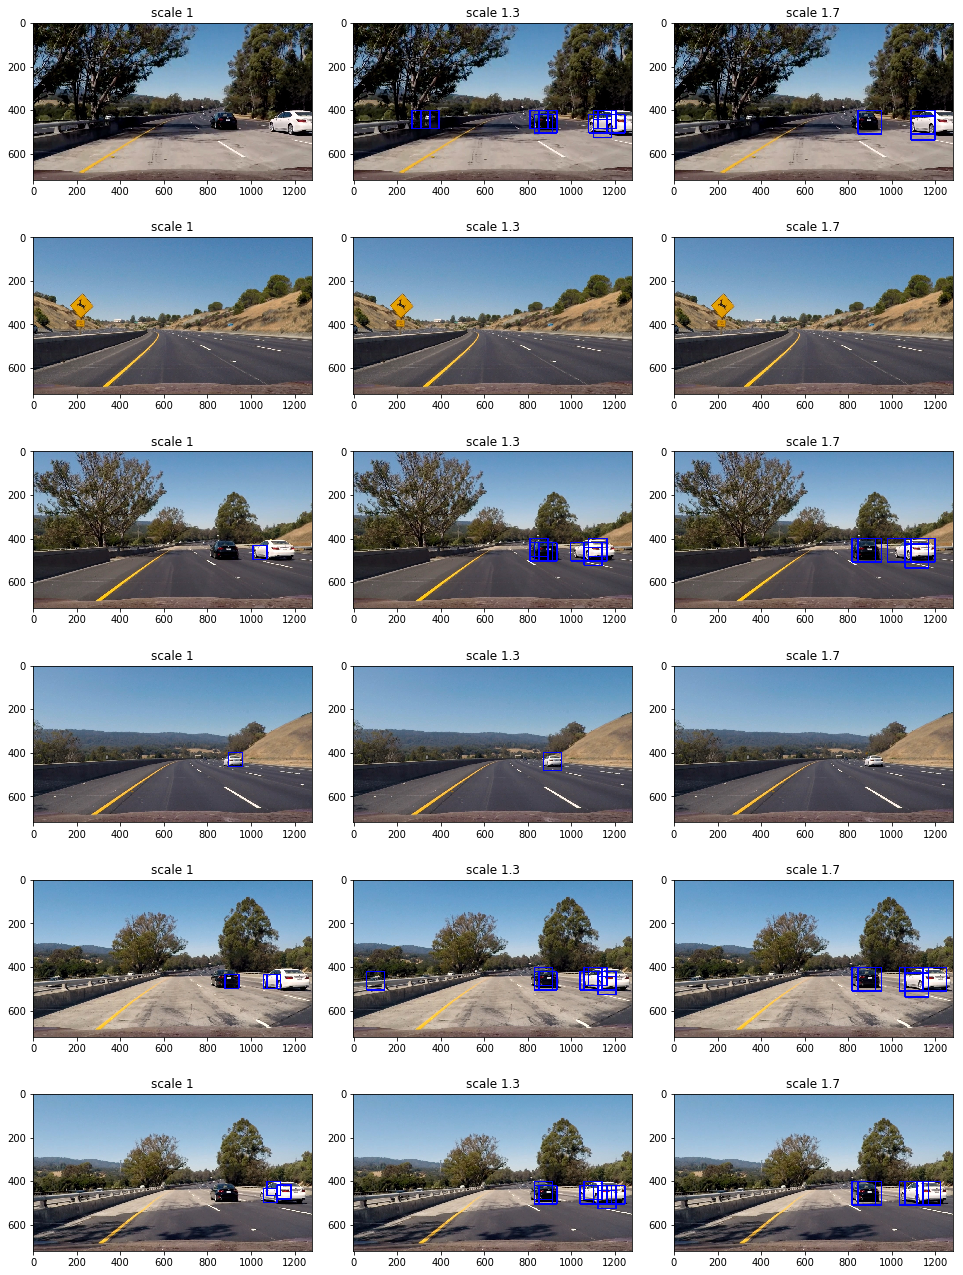

In [55]:
test_imgs = load_imgs('test_images/*.jpg')
scales = [1, 1.3, 1.7]
titles = ['scale {}'.format(scale) for scale in scales]
output_imgs = [[draw_boxes(img, find_cars(img, scale=scale)) for img in test_imgs] for scale in scales]
show_imgs(output_imgs, titles=titles, img_size=(4.5, 3))

## Video pipeline

### Visualizing pipeline

In [52]:
def get_heatmap(size, boxes):
    heatmap = np.zeros(size)
    
    for box in boxes:
        heatmap[box[0][1]:box[1][1], box[0][0]:box[1][0]] += 1

    return heatmap

def flatten(lst):
    return [e for l in lst for e in l]

def draw_labeled_boxes(img, labels):
    for label in range(1, labels[1]+1):
        nonzero = (labels[0] == label).nonzero()
        
        nonzero_y = np.array(nonzero[0])
        nonzero_x = np.array(nonzero[1])
        
        box = ((np.min(nonzero_x), np.min(nonzero_y)), (np.max(nonzero_x), np.max(nonzero_y)))
        cv2.rectangle(img, box[0], box[1], (0,0,255), 6)

    return img

def to_binary(heat_img, threshold):
    binary_img = np.zeros_like(heat_img)
    binary_img[heat_img >= threshold] = 1
    return binary_img

def merge_binaries(binary_imgs):
    merged = np.zeros_like(binary_imgs[0])
    
    for binary_img in binary_imgs:
        merged += binary_img
        
    return merged   

def show_pipeline(imgs, scales=[1.3, 1.7], buffer_size=10, heat_thresh=2, buffer_thresh=0.5):    
    buffer = []
    
    box_imgs = []
    heat_imgs = []
    binary_imgs = []
    merged_imgs = []
    output_imgs = []

    for img in imgs:
        boxes = flatten([find_cars(img, scale=scale) for scale in scales])
        box_imgs.append(draw_boxes(img, boxes))

        heat_img = get_heatmap(img.shape[:2], boxes)
        heat_imgs.append(heat_img)

        binary_img = to_binary(heat_img, heat_thresh)
        binary_imgs.append(binary_img)

        buffer.append(binary_img)
        buffer = buffer[-buffer_size:]

        merged_img = merge_binaries(buffer)
        merged_img = to_binary(merged_img, len(buffer) * buffer_thresh)
        merged_imgs.append(merged_img)

        labeled = label(merged_img)
        output_imgs.append(draw_labeled_boxes(img, labeled))

    show_imgs(
        [box_imgs, heat_imgs, binary_imgs, merged_imgs, output_imgs], 
        ['boxes', 'heatmap', 'binary', 'merged', 'output'],
        img_size=(4, 2.5)
    )

### False negatives

In [11]:
clip = VideoFileClip('test_videos/project_video.mp4').subclip(15.2, 15.7)
clip.write_images_sequence('miss_frames/frame%d.jpg')

[MoviePy] Writing frames miss_frames/frame%d.jpg.

13it [00:00, 40.14it/s]              

[MoviePy]: Done writing frames miss_frames/frame%d.jpg.



['miss_frames/frame0.jpg',
 'miss_frames/frame1.jpg',
 'miss_frames/frame2.jpg',
 'miss_frames/frame3.jpg',
 'miss_frames/frame4.jpg',
 'miss_frames/frame5.jpg',
 'miss_frames/frame6.jpg',
 'miss_frames/frame7.jpg',
 'miss_frames/frame8.jpg',
 'miss_frames/frame9.jpg',
 'miss_frames/frame10.jpg',
 'miss_frames/frame11.jpg',
 'miss_frames/frame12.jpg']

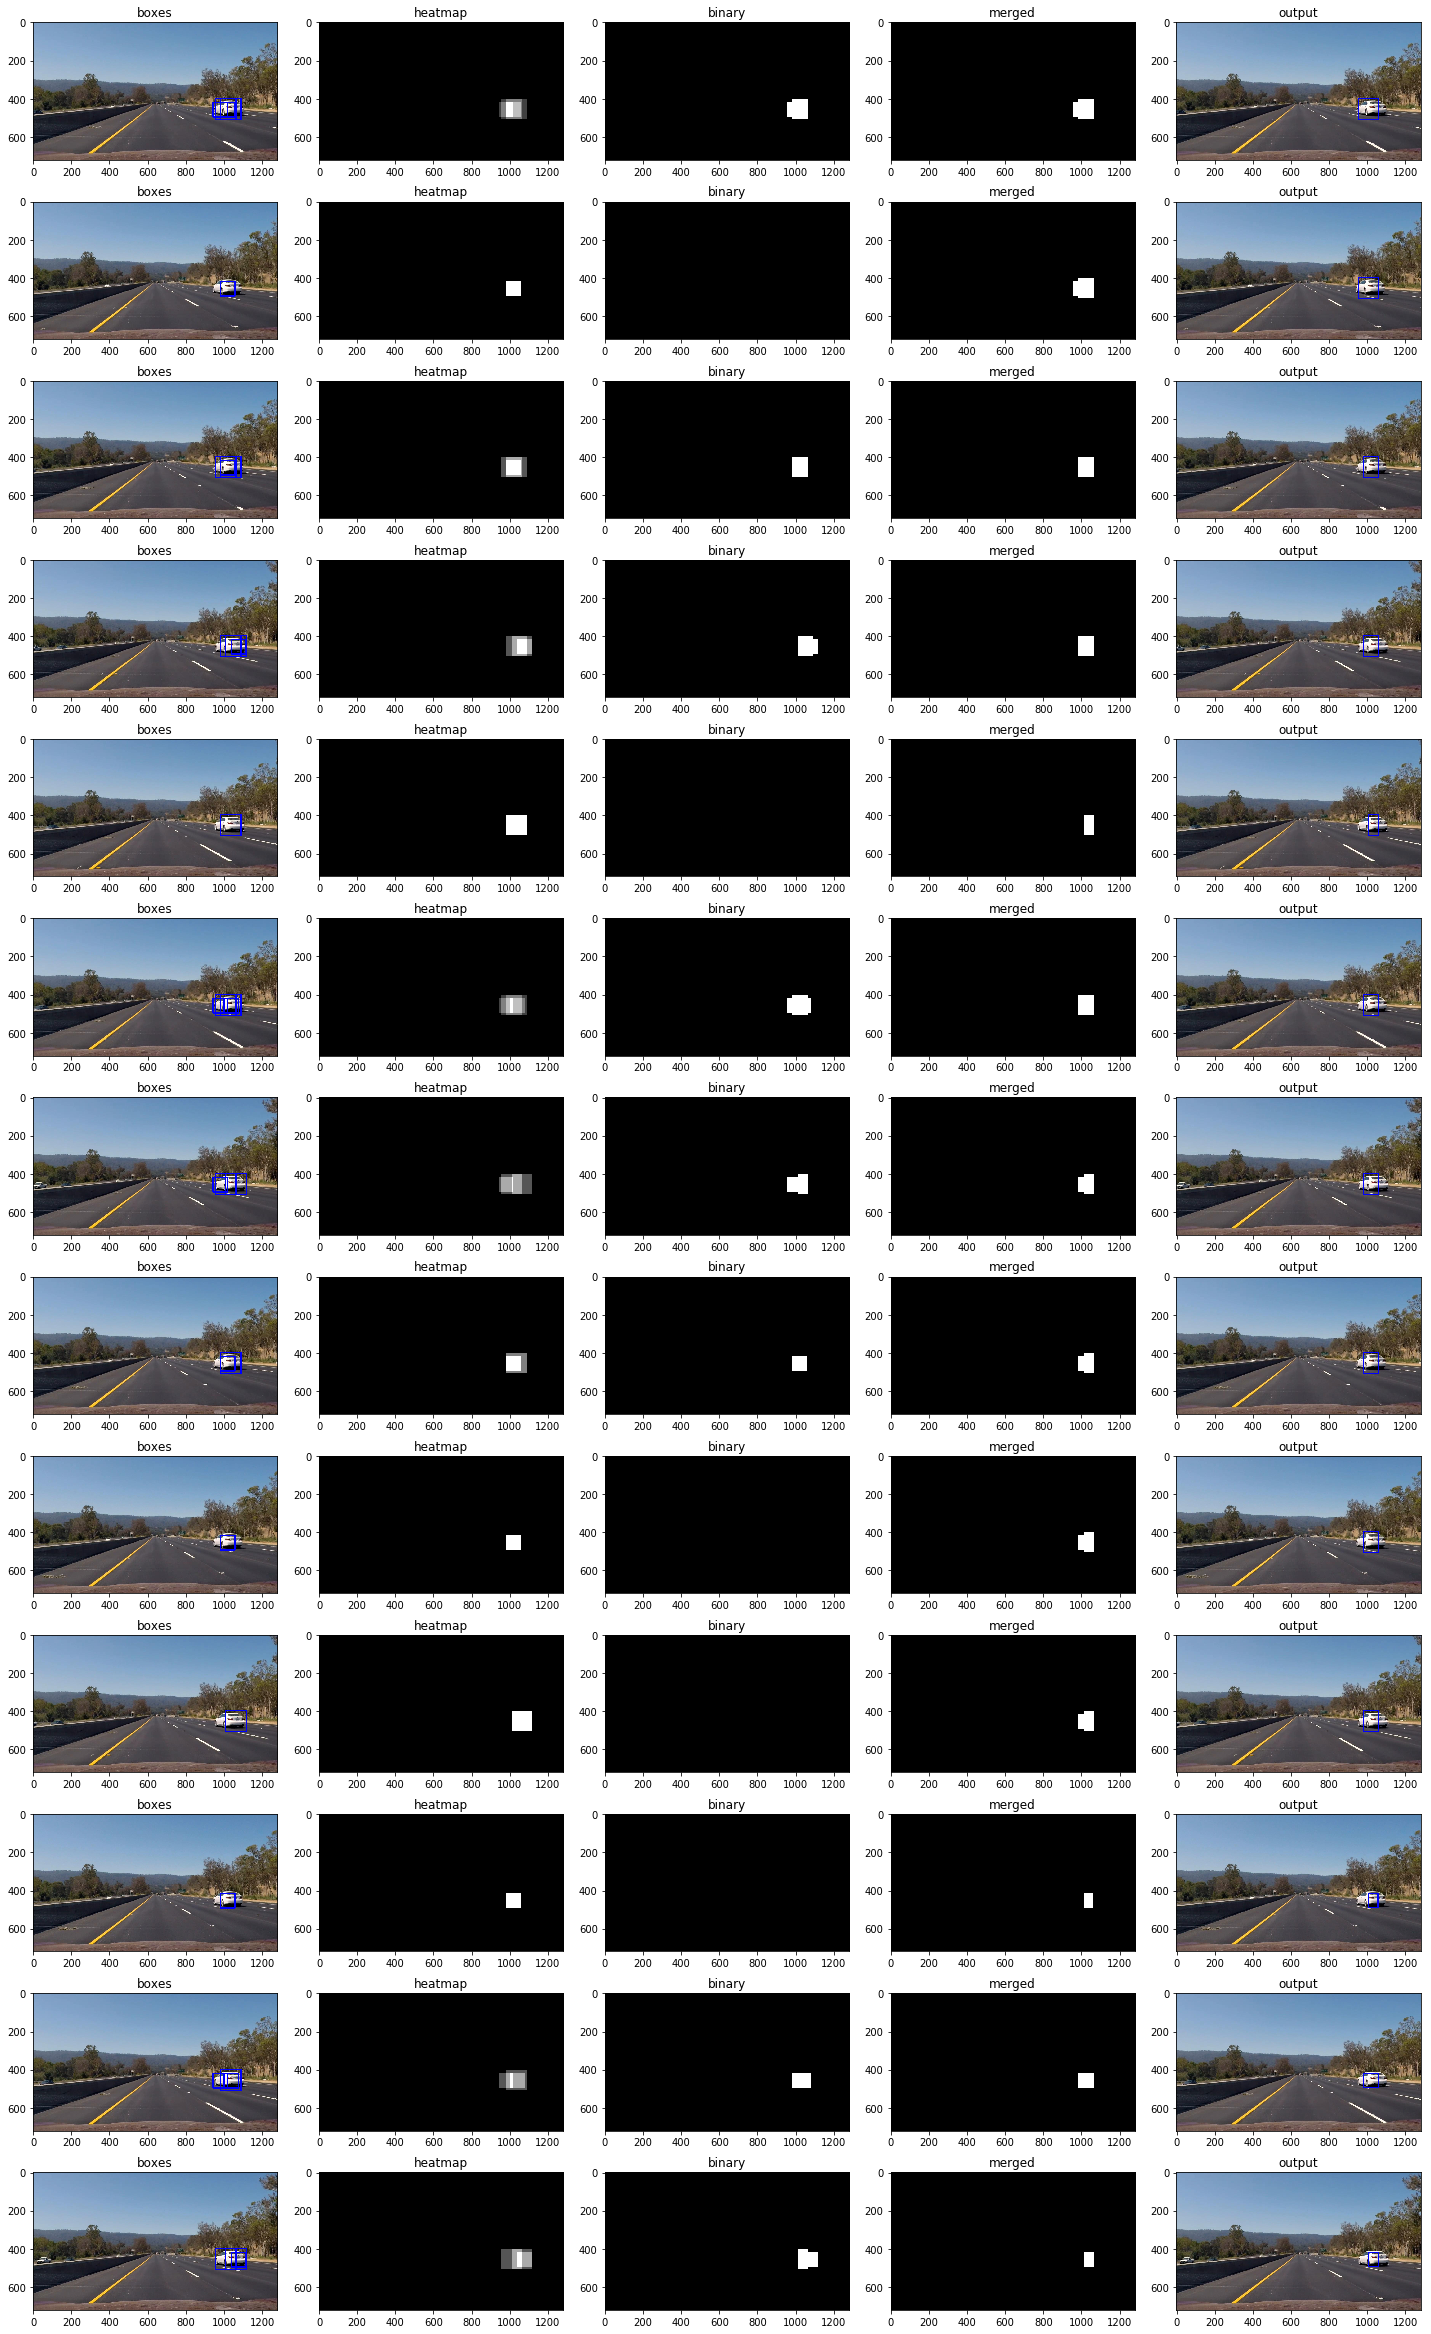

In [12]:
imgs = load_imgs('miss_frames/frame*.jpg')
show_pipeline(imgs)

### False positives

In [13]:
clip = VideoFileClip('test_videos/project_video.mp4').subclip(7.5, 8.5)
clip.write_images_sequence('false_frames/frame%d.jpg')

[MoviePy] Writing frames false_frames/frame%d.jpg.

25it [00:00, 40.13it/s]              

[MoviePy]: Done writing frames false_frames/frame%d.jpg.



['false_frames/frame0.jpg',
 'false_frames/frame1.jpg',
 'false_frames/frame2.jpg',
 'false_frames/frame3.jpg',
 'false_frames/frame4.jpg',
 'false_frames/frame5.jpg',
 'false_frames/frame6.jpg',
 'false_frames/frame7.jpg',
 'false_frames/frame8.jpg',
 'false_frames/frame9.jpg',
 'false_frames/frame10.jpg',
 'false_frames/frame11.jpg',
 'false_frames/frame12.jpg',
 'false_frames/frame13.jpg',
 'false_frames/frame14.jpg',
 'false_frames/frame15.jpg',
 'false_frames/frame16.jpg',
 'false_frames/frame17.jpg',
 'false_frames/frame18.jpg',
 'false_frames/frame19.jpg',
 'false_frames/frame20.jpg',
 'false_frames/frame21.jpg',
 'false_frames/frame22.jpg',
 'false_frames/frame23.jpg',
 'false_frames/frame24.jpg']

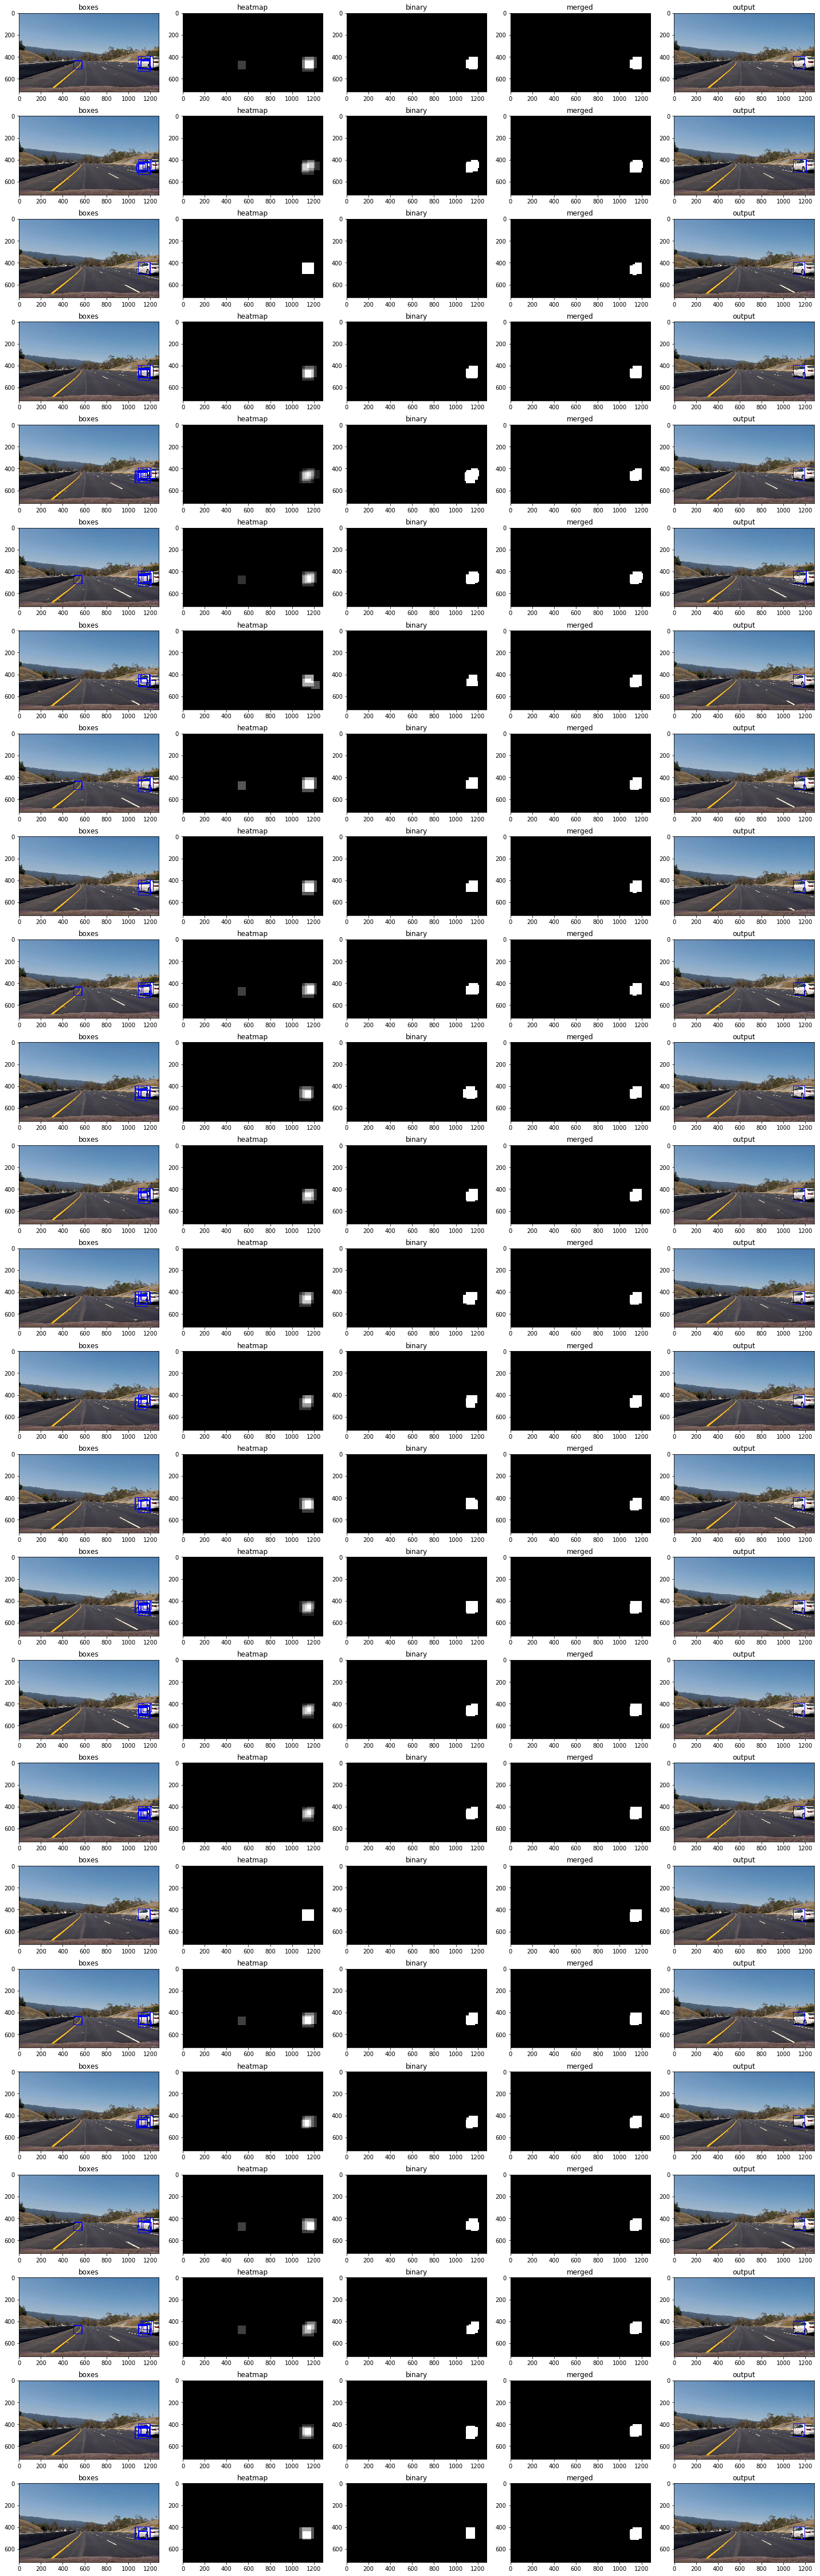

In [14]:
imgs = load_imgs('false_frames/frame*.jpg')
show_pipeline(imgs)

### Video processing

In [46]:
class VehicleDetector:
    def __init__(self, scales=[1, 1.3, 1.7], buffer_size=20, heat_thresh=1, buffer_thresh=0.5):
        self.scales = scales
        self.buffer_size = buffer_size
        self.heat_thresh = heat_thresh
        self.buffer_thresh = buffer_thresh
        
        self.buffer = []
        
    def detect(self, img):
        boxes = flatten([find_cars(img, scale=scale) for scale in self.scales])
        heat_img = get_heatmap(img.shape[:2], boxes)
        binary_img = to_binary(heat_img, self.heat_thresh)

        self.buffer.append(binary_img)
        self.buffer = self.buffer[-self.buffer_size:]

        merged_img = merge_binaries(self.buffer)
        merged_img = to_binary(merged_img, len(self.buffer) * self.buffer_thresh)
        labeled = label(merged_img)
        return draw_labeled_boxes(img, labeled)

def process_video(input_path, output_path):
    detector = VehicleDetector()
    input_clip = VideoFileClip(input_path)
    output_clip = input_clip.fl_image(detector.detect)
    %time output_clip.write_videofile(output_path, audio=False)
    
def embed_video(path):
    return HTML("""
        <video width="960" height="540" controls>
          <source src="{0}">
        </video>
    """.format(path))

In [50]:
process_video('test_videos/test_video.mp4', 'output_videos/test_video.mp4')
embed_video('output_videos/test_video.mp4')

In [49]:
process_video('test_videos/project_video.mp4', 'output_videos/project_video.mp4')
embed_video('output_videos/project_video.mp4')